<p align="center">
  <img src="https://upload.wikimedia.org/wikipedia/commons/7/78/Eindhoven_University_of_Technology_logo_new.png?20231008195526" alt="TU/e Logo" width="200px"/>
</p>

# Assignment 2: CNN, AutoML & Hyperparameter Optimization

**Course:** 1BM120 – Decision Making with Artificial Intelligence  
**Date:** *Q4 - 2025*  

---

## Group 3

- **Sadra Moosavi Lar**  
  ✉️ [s.s.moosavi.lar@student.tue.nl](mailto:s.s.moosavi.lar@student.tue.nl)

- **Floris van Hasselt**  
  ✉️ [f.j.p.v.hasselt@student.tue.nl](mailto:f.j.p.v.hasselt@student.tue.nl)

- **Sam Fiers**  
  ✉️ [s.s.w.fiers@student.tue.nl](mailto:s.s.w.fiers@student.tue.nl)

---

**Repository:** [GitHub – Group 3 Repo](https://github.com/sadra-hub/1BM120-decisiondecisionMakingWithAI)

---

## Description

We're helping a Dutch manufacturing company, Wefabricate, build an automated visual inspection system for their factory. They make a plastic part (called the front plate of an industrial plug) and want to detect defects like scratches, burns, or missing chunks using image classification.

In [1]:
# Import necessary libraries
import torch
import random
import optuna
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from support import load_dataset
from torch.utils.data import DataLoader
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "True"

In [2]:
# Set seed for reproducibility
def set_seed(seed=18):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed()

In [3]:
# Load datasets using the provided function in support.py
train_dataset, test_dataset = load_dataset()

# Create data loaders
# DataLoader is used to load the dataset in batches, which is essential for training neural networks efficiently.
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

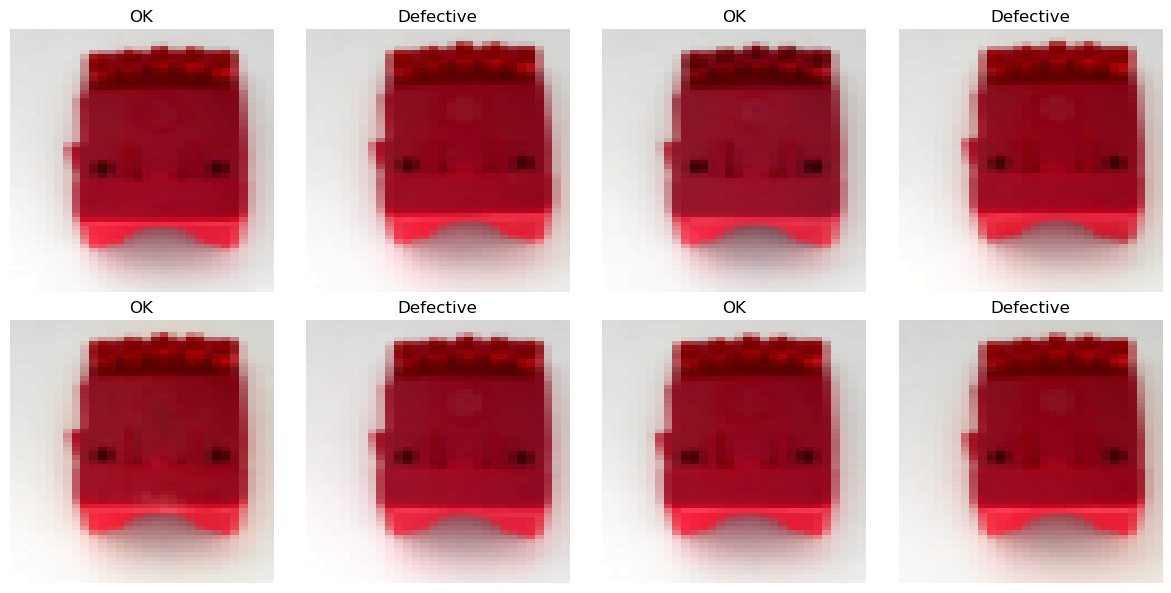

In [4]:
def show_balanced_samples(loader, classes=["OK", "Defective"]):
    ok_imgs = []
    def_imgs = []

    # Step 1: Collect 4 OK and 4 Defective samples
    for images, labels in loader:
        for img, label in zip(images, labels):
            if label == 0 and len(ok_imgs) < 4:
                ok_imgs.append(img)
            elif label == 1 and len(def_imgs) < 4:
                def_imgs.append(img)
            if len(ok_imgs) == 4 and len(def_imgs) == 4:
                break
        if len(ok_imgs) == 4 and len(def_imgs) == 4:
            break

    # Step 2: Alternate them
    ordered_imgs = []
    ordered_labels = []
    for i in range(4):
        ordered_imgs.extend([ok_imgs[i], def_imgs[i]])
        ordered_labels.extend([0, 1])

    # Step 3: Get true image shape
    _, H, W = ordered_imgs[0].shape
    aspect = W / H

    # Step 4: Plot
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    axes = axes.flatten()

    for idx in range(8):
        img = ordered_imgs[idx].permute(1, 2, 0).numpy()
        img = (img - img.min()) / (img.max() - img.min())  # Normalize

        axes[idx].imshow(img)
        axes[idx].set_title(classes[ordered_labels[idx]])
        axes[idx].axis("off")
        axes[idx].set_aspect(aspect)  # This preserves correct shape!

    plt.tight_layout()
    plt.show()

show_balanced_samples(train_loader)

In [5]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # Output: (16, H/2, W/2)
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)   # Output: (32, H/4, W/4)
        )

        # Compute the output size after conv layers dynamically
        dummy_input = torch.zeros(1, 3, 60, 30)
        dummy_output = self.features(dummy_input)
        flattened_size = dummy_output.view(1, -1).shape[1]

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flattened_size, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 2)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [6]:
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss, correct = 0.0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
    return running_loss / len(train_loader.dataset), correct / len(train_loader.dataset)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses, train_accuracies = [], []
for epoch in range(10):
    loss, acc = train(model, train_loader, criterion, optimizer, device)
    train_losses.append(loss)
    train_accuracies.append(acc)
    print(f"Epoch {epoch+1}: Loss = {loss:.4f}, Accuracy = {acc:.4f}")

Epoch 1: Loss = 0.6871, Accuracy = 0.5368
Epoch 2: Loss = 0.6791, Accuracy = 0.5588
Epoch 3: Loss = 0.7055, Accuracy = 0.4706
Epoch 4: Loss = 0.6879, Accuracy = 0.5368
Epoch 5: Loss = 0.6702, Accuracy = 0.6176
Epoch 6: Loss = 0.6509, Accuracy = 0.6250
Epoch 7: Loss = 0.6227, Accuracy = 0.6765
Epoch 8: Loss = 0.6634, Accuracy = 0.6103
Epoch 9: Loss = 0.5857, Accuracy = 0.7500
Epoch 10: Loss = 0.5350, Accuracy = 0.7574


In [7]:
def evaluate(model, test_loader, device):
    model.eval()
    correct = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
    return correct / len(test_loader.dataset)

baseline_accuracy = evaluate(model, test_loader, device)
print(f"Baseline Test Accuracy: {baseline_accuracy:.4f}")

Baseline Test Accuracy: 0.6471


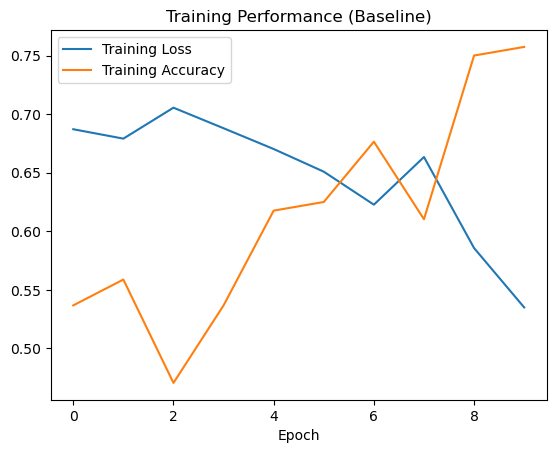

In [8]:
plt.plot(train_losses, label="Training Loss")
plt.plot(train_accuracies, label="Training Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.title("Training Performance (Baseline)")
plt.show()

In [9]:
def objective(trial):
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    dropout = trial.suggest_float("dropout", 0.1, 0.7)
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD"])
    batch_size = trial.suggest_categorical("batch_size", [16, 32])
    num_filters = trial.suggest_int("num_filters", 16, 64, step=16)

    class TunedCNN(nn.Module):
        def __init__(self):
            super(TunedCNN, self).__init__()
            self.features = nn.Sequential(
                nn.Conv2d(3, num_filters, 3, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(2),
                nn.Conv2d(num_filters, num_filters * 2, 3, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(2)
            )

            # Dynamically determine flattened size
            with torch.no_grad():
                dummy_input = torch.zeros(1, 3, 60, 30)  # Your image size
                dummy_out = self.features(dummy_input)
                self.flattened_size = dummy_out.view(1, -1).shape[1]

            self.classifier = nn.Sequential(
                nn.Flatten(),
                nn.Linear(self.flattened_size, 128),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.Linear(128, 2)
            )

        def forward(self, x):
            x = self.features(x)
            x = self.classifier(x)
            return x
    
    model = TunedCNN().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr) if optimizer_name == "Adam" else optim.SGD(model.parameters(), lr=lr)

    loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    loss, acc = train(model, loader, criterion, optimizer, device)
    return acc

In [10]:
random_study = optuna.create_study(direction="maximize", sampler=optuna.samplers.RandomSampler())
random_study.optimize(objective, n_trials=20)
print("Best hyperparameters (random):", random_study.best_params)

[I 2025-06-03 20:27:02,230] A new study created in memory with name: no-name-eeb0d8c2-f558-4625-ae7b-86f454c00195
[I 2025-06-03 20:27:28,223] Trial 0 finished with value: 0.49264705882352944 and parameters: {'lr': 0.004125149188090964, 'dropout': 0.3062977959265385, 'optimizer': 'SGD', 'batch_size': 16, 'num_filters': 48}. Best is trial 0 with value: 0.49264705882352944.
[I 2025-06-03 20:27:54,174] Trial 1 finished with value: 0.5 and parameters: {'lr': 6.033478934919903e-05, 'dropout': 0.28172497665360874, 'optimizer': 'SGD', 'batch_size': 16, 'num_filters': 48}. Best is trial 1 with value: 0.5.
[I 2025-06-03 20:28:20,642] Trial 2 finished with value: 0.4485294117647059 and parameters: {'lr': 4.14548743217666e-05, 'dropout': 0.5655467166903576, 'optimizer': 'Adam', 'batch_size': 32, 'num_filters': 48}. Best is trial 1 with value: 0.5.
[I 2025-06-03 20:28:46,731] Trial 3 finished with value: 0.4852941176470588 and parameters: {'lr': 0.000919753618923116, 'dropout': 0.31341966227720836,

Best hyperparameters (random): {'lr': 0.0013348346145346825, 'dropout': 0.40989827888754615, 'optimizer': 'SGD', 'batch_size': 16, 'num_filters': 32}


In [11]:
tpe_study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler())
tpe_study.optimize(objective, n_trials=20)
print("Best hyperparameters (TPE):", tpe_study.best_params)

[I 2025-06-03 20:35:52,715] A new study created in memory with name: no-name-cf97f6c5-c077-4aab-a480-3dab3d1b944d
[I 2025-06-03 20:36:19,249] Trial 0 finished with value: 0.5147058823529411 and parameters: {'lr': 0.00740508712400171, 'dropout': 0.2577828731426885, 'optimizer': 'SGD', 'batch_size': 32, 'num_filters': 48}. Best is trial 0 with value: 0.5147058823529411.
[I 2025-06-03 20:36:45,557] Trial 1 finished with value: 0.49264705882352944 and parameters: {'lr': 0.0010700088344976868, 'dropout': 0.16042744007082116, 'optimizer': 'Adam', 'batch_size': 32, 'num_filters': 16}. Best is trial 0 with value: 0.5147058823529411.
[I 2025-06-03 20:37:12,123] Trial 2 finished with value: 0.5220588235294118 and parameters: {'lr': 0.0008911529395722219, 'dropout': 0.45870581580186387, 'optimizer': 'Adam', 'batch_size': 32, 'num_filters': 48}. Best is trial 2 with value: 0.5220588235294118.
[I 2025-06-03 20:37:39,585] Trial 3 finished with value: 0.5220588235294118 and parameters: {'lr': 0.00649

Best hyperparameters (TPE): {'lr': 0.0020856553562890504, 'dropout': 0.34619583029781653, 'optimizer': 'Adam', 'batch_size': 32, 'num_filters': 64}


In [12]:
best_params = tpe_study.best_params

# Recreate and train best model using best_params...
# Save weights
torch.save(model.state_dict(), "cnn_optimized.pth")

In [13]:
print("Baseline Accuracy:", baseline_accuracy)
print("Best Optimized Accuracy (TPE):", tpe_study.best_value)

Baseline Accuracy: 0.6470588235294118
Best Optimized Accuracy (TPE): 0.5735294117647058


In [14]:
# Save
torch.save(model.state_dict(), "model_weights.pth")

# Load
model.load_state_dict(torch.load("model_weights.pth"))
model.eval()

SimpleCNN(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3360, out_features=128, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=128, out_features=2, bias=True)
  )
)